In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
from skimage import color, exposure, transform

NUM_CLASSES = 26
IMG_SIZE = 200


def preprocess_img_hsv(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img


import sys
import cv2

def preprocessing_img_black_and_white(img):
    im_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    skin_ycrcb_mint = np.array((0, 133, 77))
    skin_ycrcb_maxt = np.array((255, 173, 127))
    skin_ycrcb = cv2.inRange(im_ycrcb, skin_ycrcb_mint, skin_ycrcb_maxt)
    return skin_ycrcb

In [3]:
import os

testFiles=[]
trainFiles=[]
for root, dirs, files in os.walk('./data/asl-alphabet/asl_alphabet_train/'):
     for file in files:
            if file.endswith('.jpg'):
                if not file.endswith('_test.jpg'):
                    number=file[1:file.find('.')]
                    if not number.isdigit():
                        continue
                    if(int(number)>50):
                        continue
                file_path = os.path.join(root,file)
                #print(file_path)
                if file.endswith('_test.jpg'):
                    if (not file.startswith('nothing_') and not file.startswith('space_') and not(file.startswith('del_'))):
                        testFiles.append(file_path)
                else:
                    if ((not "nothing" in file) and (not "space" in file) and (not "del" in file)):
                        trainFiles.append(file_path)
testFiles.sort()
trainFiles.sort()
print(len(testFiles))
print(len(trainFiles))

#creating the sample set of 20 test images for each alphabet
import os

testFiles=[]

for root, dirs, files in os.walk('./data/asl-alphabet/asl_alphabet_train/'): #asl_alphabet_test_sample
     for file in files:
            if file.endswith('.jpg'):
                if not file.endswith('_test.jpg'):
                    number=file[1:file.find('.')]
                    if not number.isdigit():
                        continue
                    if((int(number)<=50) or int(number)>60):
                        continue
                file_path = os.path.join(root,file)
                #print(file_path)
                if (not file.startswith('nothing_') and not file.startswith('space_') and not(file.startswith('del_'))):
                    testFiles.append(file_path)
                    
testFiles.sort()
trainFiles.sort()
print(len(testFiles))
print(len(trainFiles))

0
1300
260
1300


In [4]:
from skimage import io
import numpy as np
j=0
# numpy_array_train = np.empty([78000,200,200,3])
x_train = np.empty([1300,200,200])
y_train = []
y_train_for_df = []
alphabet_array = []
alphabet_array.append('A')
alphabet_array.append('B')
alphabet_array.append('C')
alphabet_array.append('D')
alphabet_array.append('E')
alphabet_array.append('F')
alphabet_array.append('G')
alphabet_array.append('H')
alphabet_array.append('I')
alphabet_array.append('J')
alphabet_array.append('K')
alphabet_array.append('L')
alphabet_array.append('M')
alphabet_array.append('N')
alphabet_array.append('O')
alphabet_array.append('P')
alphabet_array.append('Q')
alphabet_array.append('R')
alphabet_array.append('S')
alphabet_array.append('T')
alphabet_array.append('U')
alphabet_array.append('V')
alphabet_array.append('W')
alphabet_array.append('X')
alphabet_array.append('Y')
alphabet_array.append('Z')
k=0
print(len(trainFiles))
for i in trainFiles:    
    x_train[j]=preprocessing_img_black_and_white(io.imread(i))
    j=j+1
    y_train.append(alphabet_array[k])
    if (j%50) == 0: #j%3000 for complete
        k=k+1

print(len(x_train))
print(x_train[1299])

1300
1300
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 255. ... 255.   0.   0.]
 ...
 [  0.   0. 255. ...   0. 255.   0.]
 [  0.   0.   0. ... 255.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [5]:
from skimage import io
import numpy as np
j=0
k=0
y_test = []
x_test = np.empty([260,200,200]) 

for i in testFiles:    
    x_test[j]=preprocessing_img_black_and_white(io.imread(i))
    j=j+1
    y_test.append(alphabet_array[k])
    if (j%10) == 0:
        k=k+1


x_test.shape

(260, 200, 200)

In [6]:
y_train_np=np.asarray(y_train)
y_test_np = np.asarray(y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train_np.shape)
print(y_test_np.shape)

(1300, 200, 200)
(260, 200, 200)
(1300,)
(260,)


In [7]:
print(x_train.dtype)
print(x_test.dtype)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


float64
float64


In [8]:
# normalize the data values to the range [0, 1]
x_train /= 255
x_test /= 255

In [9]:
#Label Encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train_np)
df_y_train = pd.DataFrame(y_train, columns=['one_hot_encoded'])
encode_text_dummy(df_y_train, 'one_hot_encoded')
y_train = df_y_train.values


y_test = le.fit_transform(y_test_np)
df_y_test = pd.DataFrame(y_test, columns=['one_hot_encoded'])
encode_text_dummy(df_y_test, 'one_hot_encoded')
y_test = df_y_test.values

<h3>LSTM</h3>

In [11]:
from keras.layers import LSTM
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(3):
    print(i)
    model = Sequential()
    model.add(LSTM(128, activation='sigmoid', dropout=0.1, recurrent_dropout=0.1, input_shape=(200,200)))
    model.add(Dense(30, activation='sigmoid'))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')  
print()
model.load_weights('best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 8s - loss: 3.2816 - acc: 0.0292 - val_loss: 3.2641 - val_acc: 0.0385
Epoch 2/100
 - 7s - loss: 3.2649 - acc: 0.0354 - val_loss: 3.2574 - val_acc: 0.0385
Epoch 3/100
 - 7s - loss: 3.2532 - acc: 0.0415 - val_loss: 3.2452 - val_acc: 0.0538
Epoch 4/100
 - 8s - loss: 3.2336 - acc: 0.0554 - val_loss: 3.2218 - val_acc: 0.0654
Epoch 5/100
 - 8s - loss: 3.1958 - acc: 0.0877 - val_loss: 3.1895 - val_acc: 0.0615
Epoch 6/100
 - 8s - loss: 3.1493 - acc: 0.1169 - val_loss: 3.1530 - val_acc: 0.0692
Epoch 7/100
 - 8s - loss: 3.1032 - acc: 0.1162 - val_loss: 3.1089 - val_acc: 0.0846
Epoch 8/100
 - 7s - loss: 3.0583 - acc: 0.1285 - val_loss: 3.0614 - val_acc: 0.1000
Epoch 9/100
 - 7s - loss: 3.0110 - acc: 0.1208 - val_loss: 3.0230 - val_acc: 0.1038
Epoch 10/100
 - 7s - loss: 2.9645 - acc: 0.1146 - val_loss: 2.9785 - val_acc: 0.0962
Epoch 11/100
 - 7s - loss: 2.9061 - acc: 0.1285 - val_loss: 2.9084 - val_acc: 0.1154
Epoch 12/100
 - 7s - loss

 - 7s - loss: 2.3158 - acc: 0.2977 - val_loss: 2.3957 - val_acc: 0.2308
Epoch 18/100
 - 7s - loss: 2.2374 - acc: 0.3215 - val_loss: 2.3332 - val_acc: 0.2385
Epoch 19/100
 - 7s - loss: 2.1736 - acc: 0.3092 - val_loss: 2.2876 - val_acc: 0.2423
Epoch 20/100
 - 7s - loss: 2.0938 - acc: 0.3215 - val_loss: 2.2146 - val_acc: 0.2692
Epoch 21/100
 - 7s - loss: 2.0396 - acc: 0.3246 - val_loss: 2.1871 - val_acc: 0.2385
Epoch 22/100
 - 8s - loss: 1.9865 - acc: 0.3515 - val_loss: 2.1581 - val_acc: 0.2692
Epoch 23/100
 - 8s - loss: 1.9466 - acc: 0.3700 - val_loss: 2.1001 - val_acc: 0.2808
Epoch 24/100
 - 8s - loss: 1.8888 - acc: 0.3946 - val_loss: 2.0667 - val_acc: 0.2654
Epoch 25/100
 - 8s - loss: 1.8449 - acc: 0.4254 - val_loss: 2.0355 - val_acc: 0.2885
Epoch 26/100
 - 8s - loss: 1.8052 - acc: 0.4508 - val_loss: 2.0123 - val_acc: 0.3615
Epoch 27/100
 - 7s - loss: 1.7647 - acc: 0.4415 - val_loss: 2.0043 - val_acc: 0.3308
Epoch 28/100
 - 8s - loss: 1.7156 - acc: 0.4908 - val_loss: 1.9731 - val_acc: 

Epoch 46/100
 - 7s - loss: 1.0771 - acc: 0.7300 - val_loss: 1.8164 - val_acc: 0.4846
Epoch 47/100
 - 7s - loss: 1.0384 - acc: 0.7462 - val_loss: 1.7324 - val_acc: 0.4615
Epoch 48/100
 - 7s - loss: 1.0020 - acc: 0.7585 - val_loss: 1.7693 - val_acc: 0.5154
Epoch 49/100
 - 7s - loss: 0.9865 - acc: 0.7623 - val_loss: 1.7128 - val_acc: 0.5654
Epoch 50/100
 - 7s - loss: 0.9335 - acc: 0.7923 - val_loss: 1.7047 - val_acc: 0.5692
Epoch 51/100
 - 7s - loss: 0.8974 - acc: 0.8015 - val_loss: 1.6076 - val_acc: 0.5615
Epoch 52/100
 - 7s - loss: 0.8867 - acc: 0.8062 - val_loss: 1.6351 - val_acc: 0.5808
Epoch 53/100
 - 7s - loss: 0.8411 - acc: 0.8146 - val_loss: 1.5981 - val_acc: 0.5846
Epoch 54/100
 - 7s - loss: 0.8286 - acc: 0.8246 - val_loss: 1.5555 - val_acc: 0.5923
Epoch 55/100
 - 7s - loss: 0.7806 - acc: 0.8446 - val_loss: 1.6025 - val_acc: 0.5885
Epoch 56/100
 - 7s - loss: 0.7613 - acc: 0.8462 - val_loss: 1.5948 - val_acc: 0.6462
Epoch 57/100
 - 7s - loss: 0.7411 - acc: 0.8485 - val_loss: 1.576

Plotting confusion matrix


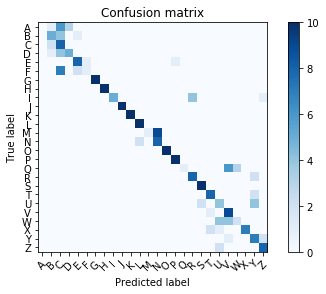

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        10
          1       0.56      0.50      0.53        10
          2       0.28      0.80      0.41        10
          3       0.62      0.50      0.56        10
          4       0.73      0.80      0.76        10
          5       0.50      0.10      0.17        10
          6       1.00      1.00      1.00        10
          7       1.00      1.00      1.00        10
          8       1.00      0.50      0.67        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       0.83      1.00      0.91        10
         12       1.00      0.10      0.18        10
         13       0.47      0.80      0.59        10
         14       1.00      1.00      1.00        10
         15       0.91      1.00      0.95        10
         16       1.00      0.10      0.18        10
         17       0.67      0.80      0.73   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
#Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_true, pred))
print("Precision :", metrics.accuracy_score(y_true, pred))

In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1300, 200, 200)
(260, 200, 200)
(1300, 26)
(260, 26)


<h3> Conv1D -> LSTM -> Neural Network</h3>

In [35]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
for i in range(5):
    print(i)
    model = Sequential()
    
    model.add(Conv1D(200, kernel_size=9, padding='valid', activation='sigmoid', input_shape=(200,200)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(128, activation='sigmoid'))
    model.add(Dense(107, activation='sigmoid'))    
    model.add(Dropout(0.1))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')  
print()
model.load_weights('best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 9s - loss: 3.3162 - val_loss: 3.2186
Epoch 2/100
 - 6s - loss: 3.1141 - val_loss: 2.9372
Epoch 3/100
 - 6s - loss: 2.8482 - val_loss: 2.7372
Epoch 4/100
 - 6s - loss: 2.6362 - val_loss: 2.5293
Epoch 5/100
 - 6s - loss: 2.4285 - val_loss: 2.4011
Epoch 6/100
 - 6s - loss: 2.2405 - val_loss: 2.2613
Epoch 7/100
 - 6s - loss: 2.1024 - val_loss: 2.1887
Epoch 8/100
 - 6s - loss: 1.9735 - val_loss: 2.0811
Epoch 9/100
 - 6s - loss: 1.8709 - val_loss: 2.0161
Epoch 10/100
 - 6s - loss: 1.7847 - val_loss: 1.9357
Epoch 11/100
 - 6s - loss: 1.6852 - val_loss: 1.9283
Epoch 12/100
 - 6s - loss: 1.5794 - val_loss: 1.8571
Epoch 13/100
 - 6s - loss: 1.5025 - val_loss: 1.8661
Epoch 14/100
 - 6s - loss: 1.4617 - val_loss: 1.7800
Epoch 15/100
 - 6s - loss: 1.3931 - val_loss: 1.7841
Epoch 16/100
 - 6s - loss: 1.3253 - val_loss: 1.8663
Epoch 17/100
 - 6s - loss: 1.2816 - val_loss: 1.7579
Epoch 18/100
 - 6s - loss: 1.2300 - val_loss: 1.6937
Epoch 

Epoch 35/100
 - 6s - loss: 0.7080 - val_loss: 1.9744
Epoch 00035: early stopping
4
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 9s - loss: 3.3235 - val_loss: 3.2347
Epoch 2/100
 - 6s - loss: 3.1488 - val_loss: 2.9870
Epoch 3/100
 - 6s - loss: 2.8840 - val_loss: 2.8068
Epoch 4/100
 - 6s - loss: 2.6962 - val_loss: 2.6622
Epoch 5/100
 - 6s - loss: 2.5253 - val_loss: 2.5188
Epoch 6/100
 - 6s - loss: 2.3371 - val_loss: 2.3818
Epoch 7/100
 - 6s - loss: 2.1323 - val_loss: 2.2422
Epoch 8/100
 - 6s - loss: 1.9747 - val_loss: 2.1117
Epoch 9/100
 - 6s - loss: 1.8327 - val_loss: 2.0169
Epoch 10/100
 - 6s - loss: 1.7106 - val_loss: 1.9220
Epoch 11/100
 - 6s - loss: 1.5945 - val_loss: 1.8585
Epoch 12/100
 - 6s - loss: 1.5051 - val_loss: 1.8387
Epoch 13/100
 - 6s - loss: 1.4185 - val_loss: 1.8258
Epoch 14/100
 - 6s - loss: 1.3561 - val_loss: 1.7459
Epoch 15/100
 - 6s - loss: 1.2860 - val_loss: 1.7461
Epoch 16/100
 - 6s - loss: 1.2234 - val_loss: 1.7633
Epoch 17/100
 - 6s - loss: 1.17

Plotting confusion matrix


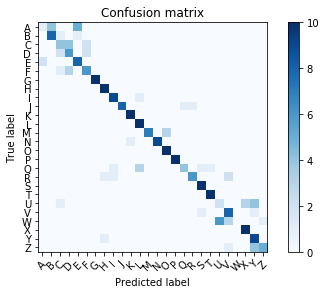

             precision    recall  f1-score   support

          0       0.33      0.10      0.15        10
          1       0.67      0.80      0.73        10
          2       0.44      0.40      0.42        10
          3       0.46      0.60      0.52        10
          4       0.57      0.80      0.67        10
          5       0.60      0.60      0.60        10
          6       1.00      1.00      1.00        10
          7       0.83      1.00      0.91        10
          8       0.82      0.90      0.86        10
          9       1.00      0.80      0.89        10
         10       0.91      1.00      0.95        10
         11       0.71      1.00      0.83        10
         12       1.00      0.70      0.82        10
         13       1.00      0.90      0.95        10
         14       0.77      1.00      0.87        10
         15       1.00      1.00      1.00        10
         16       0.80      0.40      0.53        10
         17       0.86      0.60      0.71   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
#Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_true, pred))
print("Precision :", metrics.accuracy_score(y_true, pred))
